# Implement Vision Transformer (ViT) model from scratch

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_Vision_transformer.ipynb)

In this tutorial we implement from scratch the Vision Transformer (ViT) model based on the paper by Dosovitskiy et al: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929). We load the ImageNet pretrained weights and finetune this model on [Food 101](https://huggingface.co/datasets/ethz/food101) dataset.
This tutorial is originally inspired by [HuggingFace Image classification tutorial](https://huggingface.co/docs/transformers/tasks/image_classification).

## Requirements installation

We will need to install the following Python packages:
- HuggingFace [Datasets](https://huggingface.co/docs/datasets/) will be used for dataset provision
- [TorchVision](https://pytorch.org/vision) will be used for image augmentations
- [grain](https://github.com/google/grain/) will be be used for efficient data loading
- [tqdm](https://tqdm.github.io/) for a progress bar to monitor the training progress.
- [Matplotlib](https://matplotlib.org/stable/) will be used for visualization purposes

In [1]:
# !pip install -U datasets grain torchvision tqdm matplotlib
# !pip install -U flax optax

In [2]:
import jax
import flax
import optax
print("Jax version:", jax.__version__)
print("Flax version:", flax.__version__)
print("Optax version:", optax.__version__)

Jax version: 0.4.34
Flax version: 0.10.1
Optax version: 0.2.4


## Vision Transformer implementation

Vision Transformer (ViT) architecture contains the following block:
- Patch and position embedding
- Transformer Encoder
- Classification head

![ViT-architecture](https://github.com/google-research/vision_transformer/raw/main/vit_figure.png)

Original JAX implementation can be found [here](https://github.com/google-research/vision_transformer/).

In [3]:
import jax.numpy as jnp
from flax import nnx


class VisionTransformer(nnx.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        in_channels: int = 3,
        img_size: int = 224,
        patch_size: int = 16,
        num_layers: int = 12,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        # Patch and position embedding
        n_patches = (img_size // patch_size) ** 2
        self.patch_embeddings = nnx.Conv(
            in_channels,
            hidden_size,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            use_bias=True,
            rngs=rngs,
        )

        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        self.position_embeddings = nnx.Param(
            initializer(rngs.params(), (1, n_patches + 1, hidden_size), jnp.float32)
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

        self.cls_token = nnx.Param(jnp.zeros((1, 1, hidden_size)))

        # Transformer Encoder blocks
        self.encoder = nnx.Sequential(*[
            TransformerEncoder(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
            for i in range(num_layers)
        ])
        self.final_norm = nnx.LayerNorm(hidden_size, rngs=rngs)

        # Classification head
        self.classifier = nnx.Linear(hidden_size, num_classes, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        # Patch and position embedding
        patches = self.patch_embeddings(x)
        batch_size = patches.shape[0]
        patches = patches.reshape(batch_size, -1, patches.shape[-1])

        cls_token = jnp.tile(self.cls_token, [batch_size, 1, 1])
        x = jnp.concat([cls_token, patches], axis=1)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        # Encoder blocks
        x = self.encoder(embeddings)
        x = self.final_norm(x)

        # fetch the first token
        x = x[:, 0]

        # Classification
        return self.classifier(x)


class TransformerEncoder(nnx.Module):
    def __init__(
        self,
        hidden_size: int,
        mlp_dim: int,
        num_heads: int,
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:

        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            dropout_rate=dropout_rate,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            rngs=rngs,
        )
        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

        self.mlp = nnx.Sequential(
            nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
            nnx.gelu,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
            nnx.Dropout(dropout_rate, rngs=rngs),
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


x = jnp.ones((4, 224, 224, 3))
model = VisionTransformer(num_classes=1000)
y = model(x)
print("Predictions shape: ", y.shape)

Predictions shape:  (4, 1000)


Let's now load the weights pretrained on the ImageNet dataset using HuggingFace Transformers. We load all weights and check whether we have consistent results with the reference model.

In [4]:
from transformers import FlaxViTForImageClassification

tf_model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [5]:
def vit_inplace_copy_weights(*, src_model, dst_model):
    assert isinstance(src_model, FlaxViTForImageClassification)
    assert isinstance(dst_model, VisionTransformer)

    tf_model_params = src_model.params
    tf_model_params_fstate = nnx.traversals.flatten_mapping(tf_model_params)

    flax_model_params = nnx.state(dst_model, nnx.Param)
    flax_model_params_fstate = flax_model_params.flat_state()

    params_name_mapping = {
        ("cls_token",): ("vit", "embeddings", "cls_token"),
        ("position_embeddings",): ("vit", "embeddings", "position_embeddings"),
        **{
            ("patch_embeddings", x): ("vit", "embeddings", "patch_embeddings", "projection", x)
            for x in ["kernel", "bias"]
        },
        **{
            ("encoder", "layers", i, "attn", y, x): (
                "vit", "encoder", "layer", str(i), "attention", "attention", y, x
            )
            for x in ["kernel", "bias"]
            for y in ["key", "value", "query"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "attn", "out", x): (
                "vit", "encoder", "layer", str(i), "attention", "output", "dense", x
            )
            for x in ["kernel", "bias"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "mlp", "layers", y1, x): (
                "vit", "encoder", "layer", str(i), y2, "dense", x
            )
            for x in ["kernel", "bias"]
            for y1, y2 in [(0, "intermediate"), (3, "output")]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, y1, x): (
                "vit", "encoder", "layer", str(i), y2, x
            )
            for x in ["scale", "bias"]
            for y1, y2 in [("norm1", "layernorm_before"), ("norm2", "layernorm_after")]
            for i in range(12)
        },
        **{
            ("final_norm", x): ("vit", "layernorm", x)
            for x in ["scale", "bias"]
        },
        **{
            ("classifier", x): ("classifier", x)
            for x in ["kernel", "bias"]
        }
    }

    nonvisited = set(flax_model_params_fstate.keys())

    for key1, key2 in params_name_mapping.items():
        assert key1 in flax_model_params_fstate, key1
        assert key2 in tf_model_params_fstate, (key1, key2)

        nonvisited.remove(key1)

        src_value = tf_model_params_fstate[key2]
        if key2[-1] == "kernel" and key2[-2] in ("key", "value", "query"):
            shape = src_value.shape
            src_value = src_value.reshape((shape[0], 12, 64))

        if key2[-1] == "bias" and key2[-2] in ("key", "value", "query"):
            src_value = src_value.reshape((12, 64))

        if key2[-4:] == ("attention", "output", "dense", "kernel"):
            shape = src_value.shape
            src_value = src_value.reshape((12, 64, shape[-1]))

        dst_value = flax_model_params_fstate[key1]
        assert src_value.shape == dst_value.value.shape, (key2, src_value.shape, key1, dst_value.value.shape)
        dst_value.value = src_value.copy()
        assert dst_value.value.mean() == src_value.mean(), (dst_value.value, src_value.mean())

    assert len(nonvisited) == 0, nonvisited
    nnx.update(dst_model, nnx.State.from_flat_path(flax_model_params_fstate))


vit_inplace_copy_weights(src_model=tf_model, dst_model=model)

Let's check the pretrained weights of our model and compare with the reference model results:

2024-11-27 12:16:59.113948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732709819.131675  191323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732709819.137058  191323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


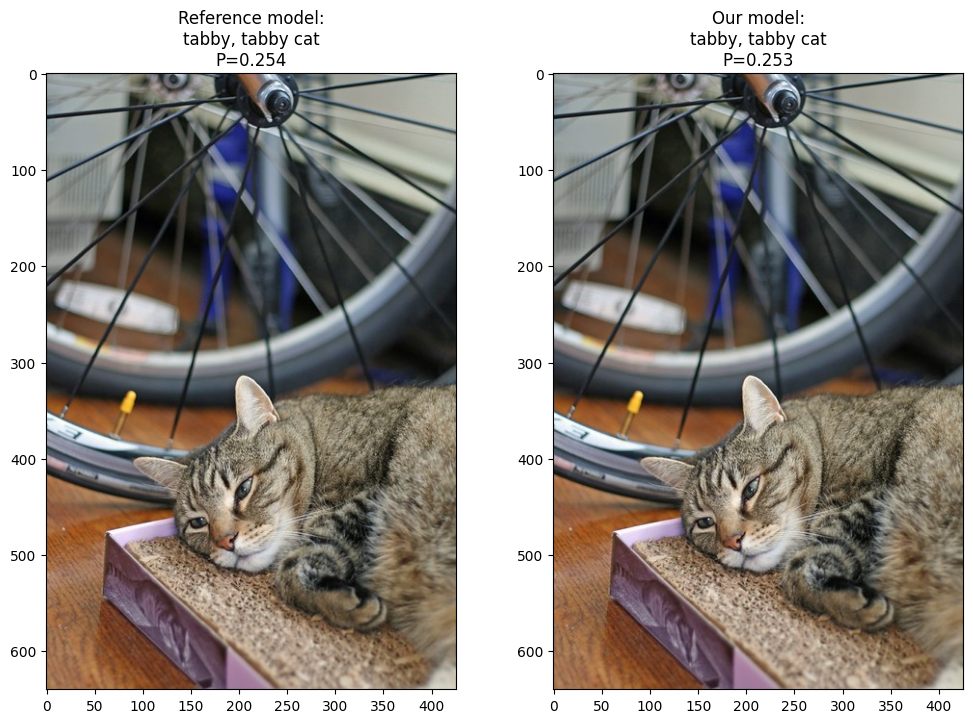

In [6]:
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor
from PIL import Image
import requests

url = "https://farm2.staticflickr.com/1152/1151216944_1525126615_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="np")
outputs = tf_model(**inputs)
logits = outputs.logits


model.eval()
x = jnp.transpose(inputs["pixel_values"], axes=(0, 2, 3, 1))
output = model(x)

# model predicts one of the 1000 ImageNet classes
ref_class_idx = logits.argmax(-1).item()
pred_class_idx = output.argmax(-1).item()
assert jnp.abs(logits[0, :] - output[0, :]).max() < 0.1

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].set_title(
    f"Reference model:\n{tf_model.config.id2label[ref_class_idx]}\nP={nnx.softmax(logits, axis=-1)[0, ref_class_idx]:.3f}"
)
axs[0].imshow(image)
axs[1].set_title(
    f"Our model:\n{tf_model.config.id2label[pred_class_idx]}\nP={nnx.softmax(output, axis=-1)[0, pred_class_idx]:.3f}"
)
axs[1].imshow(image)

Now let's replace the classifier with a smaller fully-connected layer returning 20 classes instead of 1000:

In [7]:
model.classifier = nnx.Linear(model.classifier.in_features, 20, rngs=nnx.Rngs(0))

x = jnp.ones((4, 224, 224, 3))
y = model(x)
print("Predictions shape: ", y.shape)

Predictions shape:  (4, 20)


In the following sections we set up a image classification dataset and train this model.

## Food 101 dataset

In the this tutorial we use [Food 101](https://huggingface.co/datasets/ethz/food101) dataset which consists of 101 food categories, with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

We will download the data using [HuggingFace Datasets](https://huggingface.co/docs/datasets/) and select 20 classes to reduce the dataset size and the model training time. We will be using [TorchVision](https://pytorch.org/vision) to transform input images and [`grain`](https://github.com/google/grain/) for efficient data loading.

In [8]:
from datasets import load_dataset

# Select first 20 classes to reduce the dataset size and the training time.
train_size = 20 * 750
val_size = 20 * 250

train_dataset = load_dataset("food101", split=f"train[:{train_size}]")
val_dataset = load_dataset("food101", split=f"validation[:{val_size}]")

# Let's create labels mapping where we map current labels between 0 and 19
labels_mapping = {}
index = 0
for i in range(0, len(val_dataset), 250):
    label = val_dataset[i]["label"]
    if label not in labels_mapping:
        labels_mapping[label] = index
        index += 1

inv_labels_mapping = {v: k for k, v in labels_mapping.items()}

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 15000
Validation dataset size: 5000


In [9]:
import matplotlib.pyplot as plt


def display_datapoints(*datapoints, tag="", names_map=None):
    num_samples = len(datapoints)

    fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
    for i, datapoint in enumerate(datapoints):
        if isinstance(datapoint, dict):
            img, label = datapoint["image"], datapoint["label"]
        else:
            img, label = datapoint

        if hasattr(img, "dtype") and img.dtype in (np.float32, ):
            img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

        label_str = f" ({names_map[label]})" if names_map is not None else ""
        axs[i].set_title(f"{tag}Label: {label}{label_str}")
        axs[i].imshow(img)

Let's display few samples of the dataset:

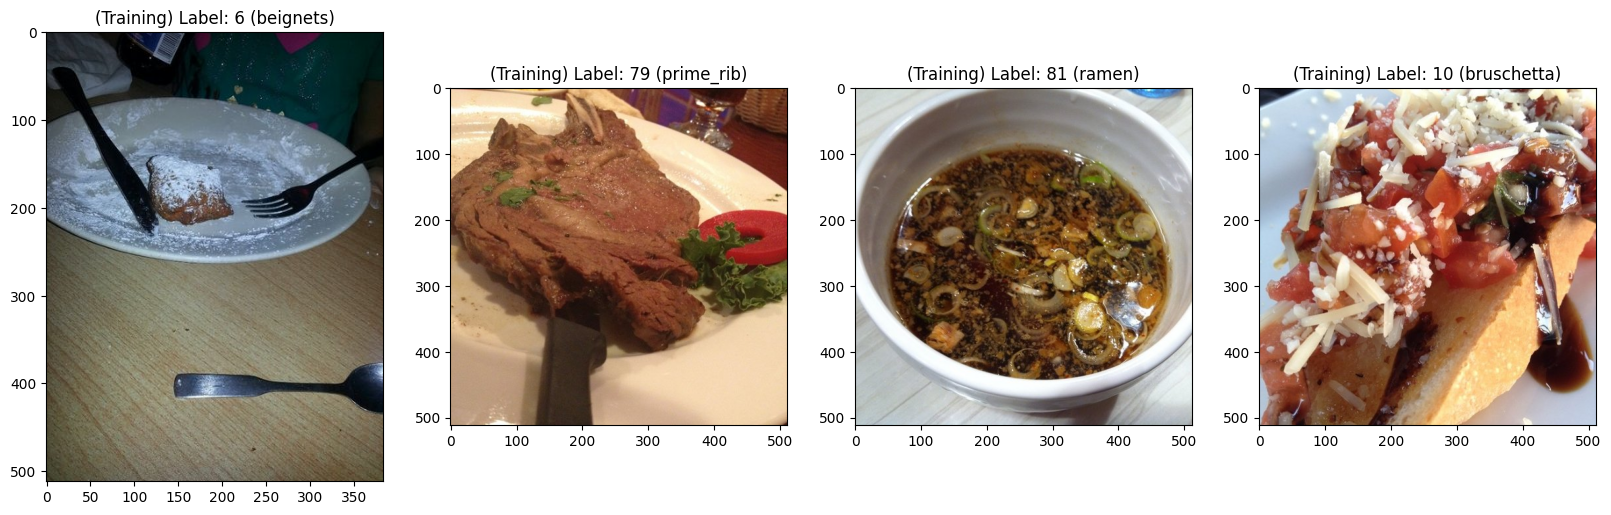

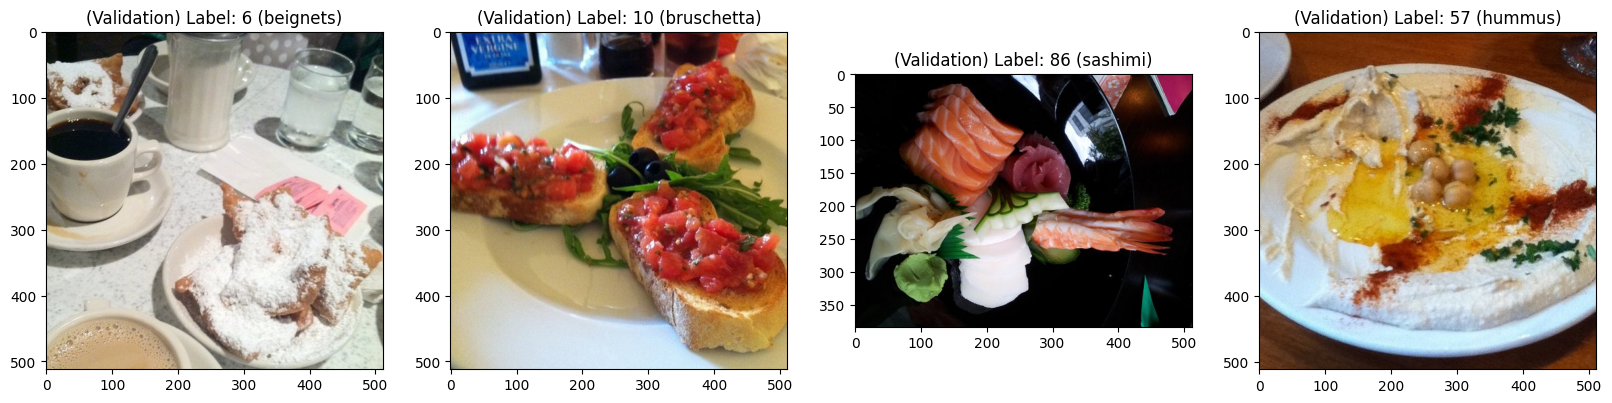

In [10]:
display_datapoints(
    train_dataset[0], train_dataset[1000], train_dataset[2000], train_dataset[3000],
    tag="(Training) ",
    names_map=train_dataset.features["label"].names
)

display_datapoints(
    val_dataset[0], val_dataset[1000], val_dataset[2000], val_dataset[-1],
    tag="(Validation) ",
    names_map=val_dataset.features["label"].names
)

Let's define training and testing image preprocessing methods. Training image transformations will also contain random augmentations to prevent overfitting and make trained model more robust.

In [11]:
import numpy as np
from torchvision.transforms import v2 as T


img_size = 224


def to_np_array(pil_image):
  return np.asarray(pil_image.convert("RGB"))


def normalize(image):
    # Image preprocessing matches the one of pretrained ViT
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = image.astype(np.float32) / 255.0
    return (image - mean) / std


tv_train_transforms = T.Compose([
    T.RandomResizedCrop((img_size, img_size), scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


tv_test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


def get_transform(fn):
    def wrapper(batch):
        batch["image"] = [
            fn(pil_image) for pil_image in batch["image"]
        ]
        # map label index between 0 - 19
        batch["label"] = [
            labels_mapping[label] for label in batch["label"]
        ]
        return batch
    return wrapper


train_transforms = get_transform(tv_train_transforms)
val_transforms = get_transform(tv_test_transforms)

train_dataset = train_dataset.with_transform(train_transforms)
val_dataset = val_dataset.with_transform(val_transforms)

In [12]:
import grain.python as grain


seed = 12
train_batch_size = 32
val_batch_size = 2 * train_batch_size


# Create an IndexSampler with no sharding for single-device computations
train_sampler = grain.IndexSampler(
    len(train_dataset),  # The total number of samples in the data source
    shuffle=True,            # Shuffle the data to randomize the order of samples
    seed=seed,               # Set a seed for reproducibility
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,            # Iterate over the dataset for one epoch
)

val_sampler = grain.IndexSampler(
    len(val_dataset),  # The total number of samples in the data source
    shuffle=False,         # Do not shuffle the data
    seed=seed,             # Set a seed for reproducibility
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,          # Iterate over the dataset for one epoch
)


train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

# Validation dataset loader
val_loader = grain.DataLoader(
    data_source=val_dataset,
    sampler=val_sampler,                   # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,
    operations=[
        grain.Batch(val_batch_size),
    ]
)

Let's visualize training and validation batches

In [13]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [14]:
print("Training batch info:", train_batch["image"].shape, train_batch["image"].dtype, train_batch["label"].shape, train_batch["label"].dtype)
print("Validation batch info:", val_batch["image"].shape, val_batch["image"].dtype, val_batch["label"].shape, val_batch["label"].dtype)

Training batch info: (32, 224, 224, 3) float32 (32,) int64
Validation batch info: (64, 224, 224, 3) float32 (64,) int64


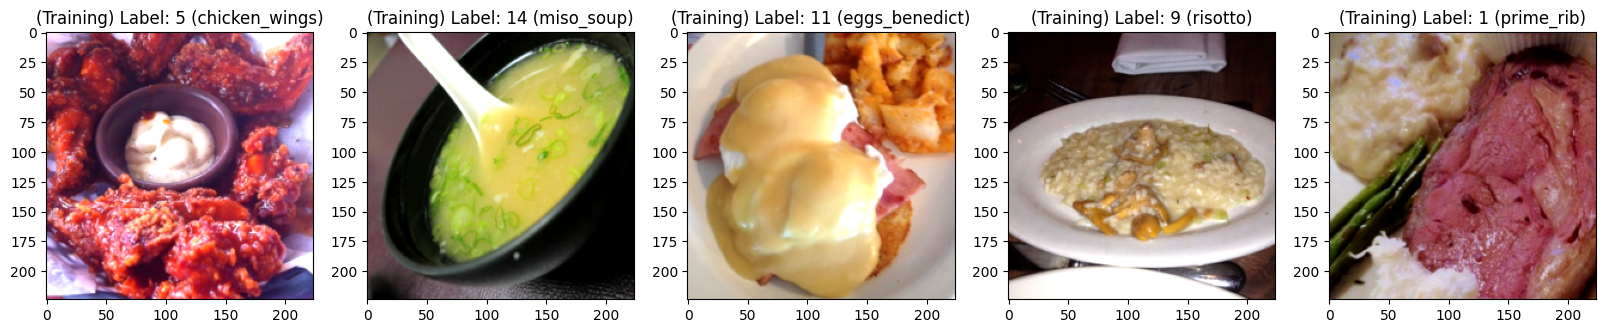

In [16]:
display_datapoints(
    *[(train_batch["image"][i], train_batch["label"][i]) for i in range(5)],
    tag="(Training) ",
    names_map={k: train_dataset.features["label"].names[v] for k, v in inv_labels_mapping.items()}
)

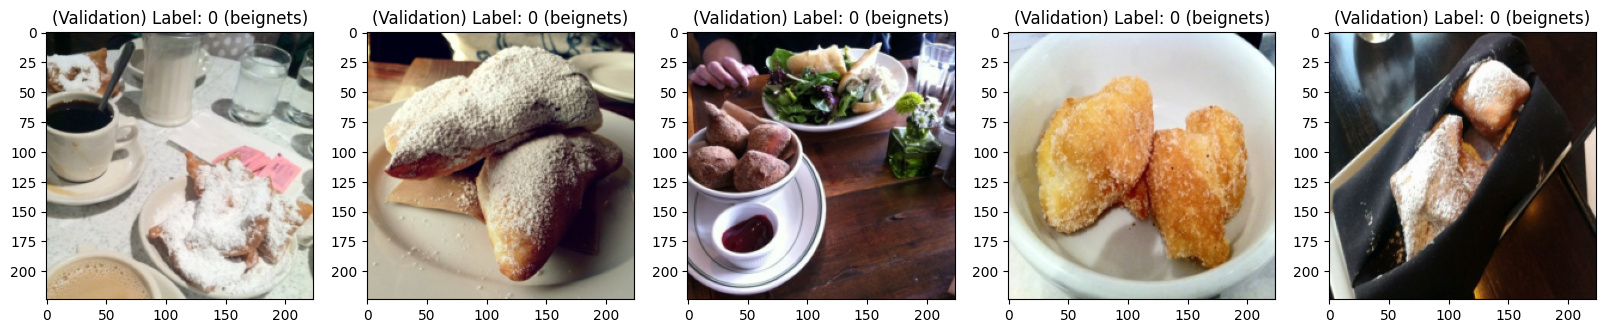

In [17]:
display_datapoints(
    *[(val_batch["image"][i], val_batch["label"][i]) for i in range(5)],
    tag="(Validation) ",
    names_map={k: val_dataset.features["label"].names[v] for k, v in inv_labels_mapping.items()}
)

## Model training

We defined training and validation datasets and the model. In this section we will train the model and define the loss function and the optimizer to perform the parameters optimization.

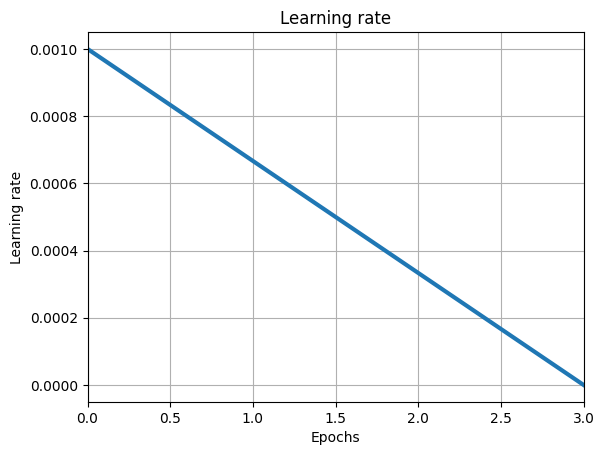

In [18]:
import optax

num_epochs = 3
learning_rate = 0.001
momentum = 0.8
total_steps = len(train_dataset) // train_batch_size

lr_schedule = optax.linear_schedule(learning_rate, 0.0, num_epochs * total_steps)

iterate_subsample = np.linspace(0, num_epochs * total_steps, 100)
plt.plot(
    np.linspace(0, num_epochs, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, num_epochs))
plt.show()


optimizer = nnx.Optimizer(model, optax.sgd(lr_schedule, momentum, nesterov=True))

In [19]:
def compute_losses_and_logits(model: nnx.Module, images: jax.Array, labels: jax.Array):
    logits = model(images)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

In [20]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, np.ndarray]
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["image"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, images, labels)

    optimizer.update(grads)  # In-place updates.

    return loss


@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, np.ndarray], eval_metrics: nnx.MultiMetric
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["image"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, images, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [21]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [22]:
import tqdm


bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for val_batch in val_loader:
        eval_step(model, val_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'val_{metric}'].append(value)

    print(f"[val] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['val_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['val_accuracy'][-1]:0.4f}")

Let's train the model.

In [23]:
%%time

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/3, [468/468], loss=0.295 [01:55<00:00]
/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[val] epoch: 1/3
- total loss: 0.2389
- Accuracy: 0.9350


[train] epoch: 1/3, [468/468], loss=0.172 [01:19<00:00] 
/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[val] epoch: 2/3
- total loss: 0.1899
- Accuracy: 0.9436


[train] epoch: 2/3, [468/468], loss=0.132 [01:18<00:00] 
/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[val] epoch: 3/3
- total loss: 0.1805
- Accuracy: 0.9454
CPU times: user 6min 56s, sys: 18.5 s, total: 7min 15s
Wall time: 5min 22s


Let's visualize collected metrics:

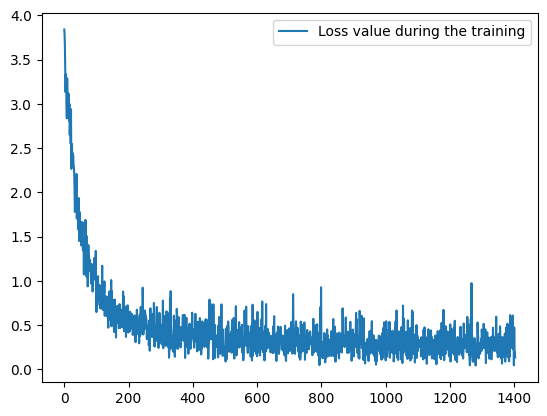

In [24]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

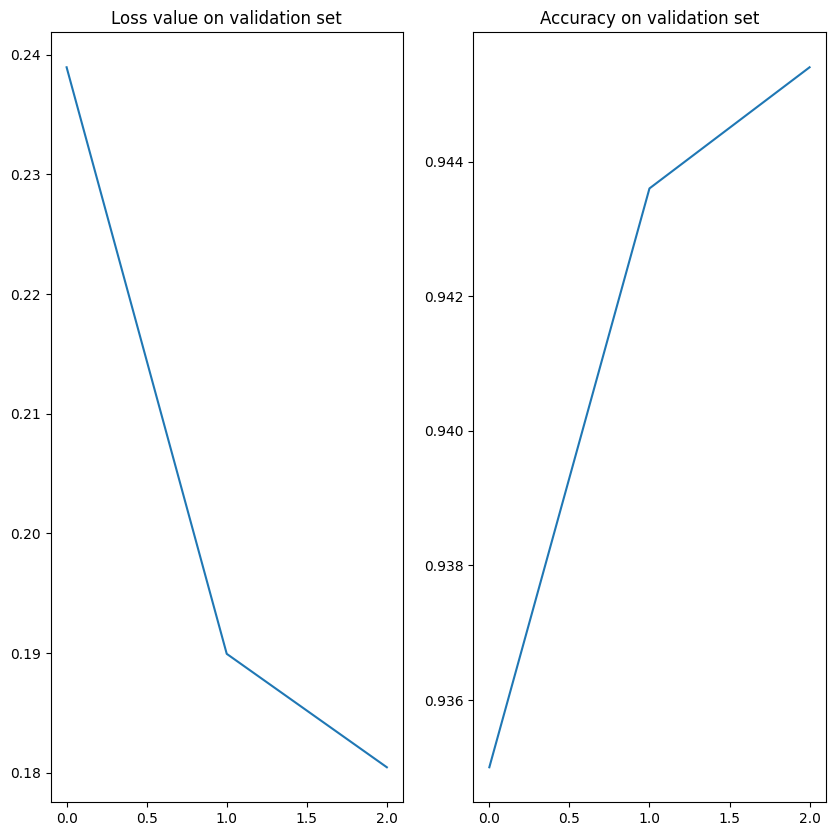

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on validation set")
axs[0].plot(eval_metrics_history["val_loss"])
axs[1].set_title("Accuracy on validation set")
axs[1].plot(eval_metrics_history["val_accuracy"])

Let's also check few model's predictions on the test data:

In [26]:
test_indices = [1, 250, 500, 750, 1000]

test_images = jnp.array([val_dataset[i]["image"] for i in test_indices])
expected_labels = [val_dataset[i]["label"] for i in test_indices]

model.eval()
preds = model(test_images)

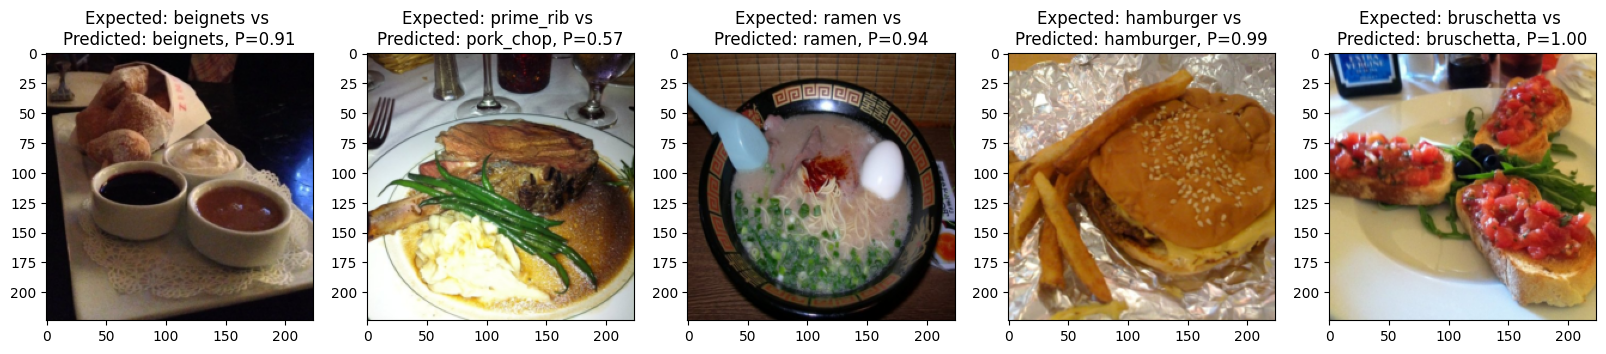

In [27]:
num_samples = len(test_indices)
names_map = train_dataset.features["label"].names

probas = nnx.softmax(preds, axis=1)
pred_labels = probas.argmax(axis=1)


fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
for i in range(num_samples):
    img, expected_label = test_images[i], expected_labels[i]

    pred_label = pred_labels[i].item()
    proba = probas[i, pred_label].item()
    if img.dtype in (np.float32, ):
        img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

    expected_label_str = names_map[inv_labels_mapping[expected_label]]
    pred_label_str = names_map[inv_labels_mapping[pred_label]]
    axs[i].set_title(f"Expected: {expected_label_str} vs \nPredicted: {pred_label_str}, P={proba:.2f}")
    axs[i].imshow(img)

## Further reading

In this tutorial we implemented from scratch the Vision Transformer model and finetuned it on a subset of Food 101 dataset. The trained model shows almost perfect classification accuracy: 95%.

- Model checkpointing and exporting using [Orbax](https://orbax.readthedocs.io/en/latest/).
- Optimizers and the learning rate scheduling using [Optax](https://optax.readthedocs.io/en/latest/).
- Freezing model's parameters using trainable parameters filtering: [example 1](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/training/optimizer.html#flax.nnx.optimizer.Optimizer.update) and [example 2](https://github.com/google/flax/issues/4167#issuecomment-2324245208).
- Other Computer Vision tutorials in [jax-ai-stack](https://jax-ai-stack.readthedocs.io/en/latest/tutorials.html).